In [ ]:
#load google drive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
#import package
import tensorflow as tf
from sklearn.metrics import confusion_matrix
import time
from sklearn.utils import shuffle
import tensorflow.keras as keras
from tensorflow.keras import layers
import tensorflow.keras.backend as K
import matplotlib.pyplot as plt
import random
import cv2
import os
import glob
import numpy as np
from google.colab.patches import cv2_imshow

In [ ]:
#Data path
data_path = "/content/gdrive/MyDrive/MVTEC/File/pill/"

In [ ]:
#Inital parameters
RGB = True
channels = 3
Image_shape = (256,256)

flip_add = True

niter = 250
batch_size = 32

Threshold = 0.05


#Generator


generators Encoder

In [ ]:
def g_e_fu():
  input_layer = layers.Input(name='input', shape=(Image_shape[0], Image_shape[1], channels))

  # Encoder
  x = layers.Conv2D(32, (5,5), strides=(1,1), padding='same', name='conv_1', kernel_regularizer = 'l2')(input_layer)
  x = layers.LeakyReLU(name='leaky_1')(x)

  x = layers.Conv2D(64, (3,3), strides=(2,2), padding='same', name='conv_2', kernel_regularizer = 'l2')(x)
  x = layers.BatchNormalization(name='norm_1')(x)
  x = layers.LeakyReLU(name='leaky_2')(x)


  x = layers.Conv2D(128, (3,3), strides=(2,2), padding='same', name='conv_3', kernel_regularizer = 'l2')(x)
  x = layers.BatchNormalization(name='norm_2')(x)
  x = layers.LeakyReLU(name='leaky_3')(x)


  x = layers.Conv2D(128, (3,3), strides=(2,2), padding='same', name='conv_4', kernel_regularizer = 'l2')(x)
  x = layers.BatchNormalization(name='norm_3')(x)
  x = layers.LeakyReLU(name='leaky_4')(x)

  x = layers.GlobalAveragePooling2D(name='g_encoder_output')(x)

  g_e = keras.models.Model(inputs=input_layer, outputs=x)

  #g_e.summary()
  return g_e

In [ ]:
input_layer = layers.Input(name='input', shape=(Image_shape[0], Image_shape[1], channels))

# Encoder
x = layers.Conv2D(32, (5,5), strides=(1,1), padding='same', name='conv_1', kernel_regularizer = 'l2')(input_layer)
x = layers.LeakyReLU(name='leaky_1')(x)

x = layers.Conv2D(64, (3,3), strides=(2,2), padding='same', name='conv_2', kernel_regularizer = 'l2')(x)
x = layers.BatchNormalization(name='norm_1')(x)
x = layers.LeakyReLU(name='leaky_2')(x)


x = layers.Conv2D(128, (3,3), strides=(2,2), padding='same', name='conv_3', kernel_regularizer = 'l2')(x)
x = layers.BatchNormalization(name='norm_2')(x)
x = layers.LeakyReLU(name='leaky_3')(x)


x = layers.Conv2D(128, (3,3), strides=(2,2), padding='same', name='conv_4', kernel_regularizer = 'l2')(x)
x = layers.BatchNormalization(name='norm_3')(x)
x = layers.LeakyReLU(name='leaky_4')(x)

x = layers.GlobalAveragePooling2D(name='g_encoder_output')(x)

g_e = keras.models.Model(inputs=input_layer, outputs=x)

g_e.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 256, 256, 3)]     0         
                                                                 
 conv_1 (Conv2D)             (None, 256, 256, 32)      2432      
                                                                 
 leaky_1 (LeakyReLU)         (None, 256, 256, 32)      0         
                                                                 
 conv_2 (Conv2D)             (None, 128, 128, 64)      18496     
                                                                 
 norm_1 (BatchNormalization)  (None, 128, 128, 64)     256       
                                                                 
 leaky_2 (LeakyReLU)         (None, 128, 128, 64)      0         
                                                                 
 conv_3 (Conv2D)             (None, 64, 64, 128)       73856 

generator

In [ ]:
def g_fu():
  input_layer = layers.Input(name='input', shape=(Image_shape[0], Image_shape[1], channels))

  x = g_e(input_layer)

  y = layers.Dense(Image_shape[0] * Image_shape[0] * 2, name='dense')(x) # 2 = 128 / 8 / 8
  y = layers.Reshape((Image_shape[0]//8, Image_shape[0]//8, 128), name='de_reshape')(y)

  y = layers.Conv2DTranspose(128, (3,3), strides=(2,2), padding='same', name='deconv_1', kernel_regularizer = 'l2')(y)
  y = layers.LeakyReLU(name='de_leaky_1')(y)

  y = layers.Conv2DTranspose(64, (3,3), strides=(2,2), padding='same', name='deconv_2', kernel_regularizer = 'l2')(y)
  y = layers.LeakyReLU(name='de_leaky_2')(y)

  y = layers.Conv2DTranspose(32, (3,3), strides=(2,2), padding='same', name='deconv_3', kernel_regularizer = 'l2')(y)
  y = layers.LeakyReLU(name='de_leaky_3')(y)

  y = layers.Conv2DTranspose(channels, (1, 1), strides=(1,1), padding='same', name='decoder_deconv_output', kernel_regularizer = 'l2', activation='tanh')(y)

  g = keras.models.Model(inputs=input_layer, outputs=y)

  #g.summary()
  return g

In [ ]:
input_layer = layers.Input(name='input', shape=(Image_shape[0], Image_shape[1], channels))

x = g_e(input_layer)

y = layers.Dense(Image_shape[0] * Image_shape[0] * 2, name='dense')(x) # 2 = 128 / 8 / 8
y = layers.Reshape((Image_shape[0]//8, Image_shape[0]//8, 128), name='de_reshape')(y)

y = layers.Conv2DTranspose(128, (3,3), strides=(2,2), padding='same', name='deconv_1', kernel_regularizer = 'l2')(y)
y = layers.LeakyReLU(name='de_leaky_1')(y)

y = layers.Conv2DTranspose(64, (3,3), strides=(2,2), padding='same', name='deconv_2', kernel_regularizer = 'l2')(y)
y = layers.LeakyReLU(name='de_leaky_2')(y)

y = layers.Conv2DTranspose(32, (3,3), strides=(2,2), padding='same', name='deconv_3', kernel_regularizer = 'l2')(y)
y = layers.LeakyReLU(name='de_leaky_3')(y)

y = layers.Conv2DTranspose(channels, (1, 1), strides=(1,1), padding='same', name='decoder_deconv_output', kernel_regularizer = 'l2', activation='tanh')(y)

g = keras.models.Model(inputs=input_layer, outputs=y)

g.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 256, 256, 3)]     0         
                                                                 
 model (Functional)          (None, 128)               243648    
                                                                 
 dense (Dense)               (None, 131072)            16908288  
                                                                 
 de_reshape (Reshape)        (None, 32, 32, 128)       0         
                                                                 
 deconv_1 (Conv2DTranspose)  (None, 64, 64, 128)       147584    
                                                                 
 de_leaky_1 (LeakyReLU)      (None, 64, 64, 128)       0         
                                                                 
 deconv_2 (Conv2DTranspose)  (None, 128, 128, 64)      7379

#Encoder After Generator

In [ ]:
input_layer = layers.Input(name='input', shape=(Image_shape[0],Image_shape[1], channels))

z = layers.Conv2D(32, (5,5), strides=(1,1), padding='same', name='encoder_conv_1', kernel_regularizer = 'l2')(input_layer)
z = layers.LeakyReLU()(z)

z = layers.Conv2D(64, (3,3), strides=(2,2), padding='same', name='encoder_conv_2', kernel_regularizer = 'l2')(z)
z = layers.BatchNormalization(name='encoder_norm_1')(z)
z = layers.LeakyReLU()(z)


z = layers.Conv2D(128, (3,3), strides=(2,2), padding='same', name='encoder_conv_3', kernel_regularizer = 'l2')(z)
z = layers.BatchNormalization(name='encoder_norm_2')(z)
z = layers.LeakyReLU()(z)

z = layers.Conv2D(128, (3,3), strides=(2,2), padding='same', name='conv_41', kernel_regularizer = 'l2')(z)
z = layers.BatchNormalization(name='encoder_norm_3')(z)
z = layers.LeakyReLU()(z)

z = layers.GlobalAveragePooling2D(name='encoder_output')(z)

encoder = keras.models.Model(input_layer, z)
encoder.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 256, 256, 3)]     0         
                                                                 
 encoder_conv_1 (Conv2D)     (None, 256, 256, 32)      2432      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 256, 256, 32)      0         
                                                                 
 encoder_conv_2 (Conv2D)     (None, 128, 128, 64)      18496     
                                                                 
 encoder_norm_1 (BatchNormal  (None, 128, 128, 64)     256       
 ization)                                                        
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 128, 128, 64)      0         
                                                           

#Feature Extractor(for discriminator)

In [ ]:
input_layer = layers.Input(name='input', shape=(Image_shape[0],Image_shape[1], channels))

f = layers.Conv2D(32, (5,5), strides=(1,1), padding='same', name='f_conv_1', kernel_regularizer = 'l2')(input_layer)
f = layers.LeakyReLU(name='f_leaky_1')(f)

f = layers.Conv2D(64, (3,3), strides=(2,2), padding='same', name='f_conv_2', kernel_regularizer = 'l2')(f)
f = layers.BatchNormalization(name='f_norm_1')(f)
f = layers.LeakyReLU(name='f_leaky_2')(f)


f = layers.Conv2D(128, (3,3), strides=(2,2), padding='same', name='f_conv_3', kernel_regularizer = 'l2')(f)
f = layers.BatchNormalization(name='f_norm_2')(f)
f = layers.LeakyReLU(name='f_leaky_3')(f)


f = layers.Conv2D(128, (3,3), strides=(2,2), padding='same', name='f_conv_4', kernel_regularizer = 'l2')(f)
f = layers.BatchNormalization(name='f_norm_3')(f)
f = layers.LeakyReLU(name='feature_output')(f)

feature_extractor = keras.models.Model(input_layer, f)

feature_extractor.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 256, 256, 3)]     0         
                                                                 
 f_conv_1 (Conv2D)           (None, 256, 256, 32)      2432      
                                                                 
 f_leaky_1 (LeakyReLU)       (None, 256, 256, 32)      0         
                                                                 
 f_conv_2 (Conv2D)           (None, 128, 128, 64)      18496     
                                                                 
 f_norm_1 (BatchNormalizatio  (None, 128, 128, 64)     256       
 n)                                                              
                                                                 
 f_leaky_2 (LeakyReLU)       (None, 128, 128, 64)      0         
                                                           

#Loss function

In [ ]:
class AdvLoss(keras.layers.Layer):
    def __init__(self, **kwargs):
        super(AdvLoss, self).__init__(**kwargs)

    def call(self, x, mask=None):
        ori_feature = feature_extractor(x[0])
        gan_feature = feature_extractor(x[1])
        return K.mean(K.square(ori_feature - K.mean(gan_feature, axis=0)))

    def get_output_shape_for(self, input_shape):
        return (input_shape[0][0], 1)
    
class CntLoss(keras.layers.Layer):
    def __init__(self, **kwargs):
        super(CntLoss, self).__init__(**kwargs)

    def call(self, x, mask=None):
        ori = x[0]
        gan = x[1]
        return K.mean(K.abs(ori - gan))

    def get_output_shape_for(self, input_shape):
        return (input_shape[0][0], 1)
    
class EncLoss(keras.layers.Layer):
    def __init__(self, **kwargs):
        super(EncLoss, self).__init__(**kwargs)

    def call(self, x, mask=None):
        ori = x[0]
        gan = x[1]
        return K.mean(K.square(g_e(ori) - encoder(gan)))

    def get_output_shape_for(self, input_shape):
        return (input_shape[0][0], 1)
    

#Gan Trainer

In [ ]:
# model for training
input_layer = layers.Input(name='input', shape=(Image_shape[0], Image_shape[1], channels))
gan = g(input_layer) # g(x)

adv_loss = AdvLoss(name='adv_loss')([input_layer, gan])
cnt_loss = CntLoss(name='cnt_loss')([input_layer, gan])
enc_loss = EncLoss(name='enc_loss')([input_layer, gan])

gan_trainer = keras.models.Model(input_layer, [adv_loss, cnt_loss, enc_loss])

# loss function
def loss(yt, yp):
    return yp

losses = {
    'adv_loss': loss,
    'cnt_loss': loss,
    'enc_loss': loss,
}

lossWeights = {'cnt_loss': 20.0, 'adv_loss': 1.0, 'enc_loss': 1.0}

# compile
gan_trainer.compile(optimizer = 'adam', loss=losses, loss_weights=lossWeights)

In [ ]:
gan_trainer.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 model_1 (Functional)           (None, 256, 256, 3)  17391875    ['input[0][0]']                  
                                                                                                  
 adv_loss (AdvLoss)             ()                   0           ['input[0][0]',                  
                                                                  'model_1[0][0]']                
                                                                                            

#Discriminator

In [ ]:
input_layer = layers.Input(name='input', shape=(Image_shape[0], Image_shape[1], channels))

f = feature_extractor(input_layer)

d = layers.GlobalAveragePooling2D(name='glb_avg')(f)
d = layers.Dense(1, activation='sigmoid', name='d_out')(d)
    
d = keras.models.Model(input_layer, d)
d.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 256, 256, 3)]     0         
                                                                 
 model_3 (Functional)        (None, 32, 32, 128)       243648    
                                                                 
 glb_avg (GlobalAveragePooli  (None, 128)              0         
 ng2D)                                                           
                                                                 
 d_out (Dense)               (None, 1)                 129       
                                                                 
Total params: 243,777
Trainable params: 243,137
Non-trainable params: 640
_________________________________________________________________


In [ ]:
d.compile(optimizer='adam', loss='binary_crossentropy')

#Load Data

In [ ]:
def read_train_data(path):
  x_train = []
  for filename in glob.glob(data_path+"train/good/**.png"):
    if channels == 1:
      x_train.append(cv2.resize(cv2.imread(filename, cv2.IMREAD_GRAYSCALE), Image_shape, interpolation=cv2.INTER_AREA))
    else:
      x_train.append(cv2.resize(cv2.imread(filename), Image_shape, interpolation=cv2.INTER_AREA))
    if flip_add and random.random()>=0:
      x_train.append(cv2.flip(x_train[-1], 1))
  x_train = shuffle(x_train)
  return x_train

In [ ]:
def reshape_x(x):
    if channels ==3:
      new_x = np.empty((len(x), Image_shape[0], Image_shape[1], channels))
    else:
       new_x = np.empty((len(x), Image_shape[0], Image_shape[1]))
    for i, e in enumerate(x):
        new_x[i] = x[i]
    return np.expand_dims(new_x, axis=-1) / 127 - 1

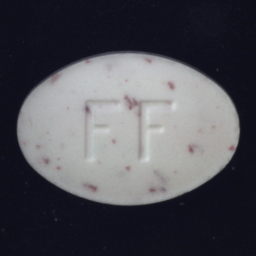

In [ ]:
#Train Data
x_train = read_train_data(data_path)
cv2_imshow(x_train[-1])
x_train_pross = reshape_x(x_train)


#Training

In [ ]:
def get_data_generator(data, batch_size=32):
    datalen = len(data)
    cnt = 0
    while True:
        idxes = np.arange(datalen)
        np.random.shuffle(idxes)
        cnt += 1
        for i in range(int(np.ceil(datalen/batch_size))):
            train_x = np.take(data, idxes[i*batch_size: (i+1) * batch_size], axis=0)
            if channels == 3:
              train_x = train_x.reshape(len(train_x),Image_shape[0],Image_shape[1],channels)
            y = np.ones(len(train_x))
            yield train_x, [y, y, y]

In [ ]:
train_data_generator = get_data_generator(x_train_pross, batch_size)

In [ ]:
for i in range(niter):
    
    ### get batch x, y ###
    x, y = train_data_generator.__next__()
        
    ### train disciminator ###
    d.trainable = True
        
    fake_x = g.predict(x)
    d_x = np.concatenate([x, fake_x], axis=0)
    d_y = np.concatenate([np.zeros(len(x)), np.ones(len(fake_x))], axis=0)
        
    d_loss = d.train_on_batch(d_x, d_y)

    ### train generator ###
    
    d.trainable = False        
    g_loss = gan_trainer.train_on_batch(x, y)
    
    if i % 25 == 0:
        print(f'niter: {i+1}, g_loss: {g_loss}, d_loss: {d_loss}')

niter: 1, g_loss: [1.4995535612106323, 0.000608476169873029, 0.038208648562431335, 0.006935865618288517], d_loss: 0.6327077746391296
niter: 26, g_loss: [1.2036396265029907, 0.0014371309662237763, 0.02982434071600437, 0.006650606635957956], d_loss: 0.46422433853149414
niter: 51, g_loss: [1.1850616931915283, 0.0003258367069065571, 0.032583143562078476, 0.007111120503395796], d_loss: 0.34813162684440613
niter: 76, g_loss: [1.183069109916687, 0.0002350727008888498, 0.03512423858046532, 0.008675307966768742], d_loss: 0.289183109998703
niter: 101, g_loss: [1.1781160831451416, 0.00017700840544421226, 0.036689698696136475, 0.010082068853080273], d_loss: 0.23870374262332916
niter: 126, g_loss: [0.9982969760894775, 0.00021890358766540885, 0.029599575325846672, 0.007141510955989361], d_loss: 0.17332041263580322
niter: 151, g_loss: [1.1735615730285645, 6.358690734487027e-05, 0.03936314955353737, 0.008327828720211983], d_loss: 0.1370583474636078
niter: 176, g_loss: [0.8765403628349304, 8.6511981862

#Test

In [ ]:
#test
def Predict(Generator, Generator_Encode,Encode, X, Y, threshold = 0.1):
  encoded = Generator_Encode.predict(X)
  encoded_gan = Encode.predict(Generator.predict(X))
  score = np.sum(np.absolute(encoded - encoded_gan), axis=-1)
  score = (score - np.min(score)) / (np.max(score) - np.min(score))
  for i in range(len(score)):
    if score[i] > threshold:
      score[i] = 1
    else:
      score[i] = 0
  score = score.astype(int)
  tn, fp, fn, tp = confusion_matrix(Y, score).ravel()
  pre = round(tp/(tp + fp)*100,1)
  recall = round(tp/(tp + fn)*100,1)
  acc = round((tp+tn) / (tp+tn+fp+fn)*100,1)
  f1 = round(2*pre*recall/(pre + recall),1)

  print('Accuracy     : {}%'.format(acc))
  print('Precision    : {}%'.format(pre))
  print('Recall      : {}%'.format(recall))
  print('F1-score     : {}%'.format(f1))

In [ ]:
def reshape_x(x):
    if channels ==3:
      new_x = np.empty((len(x), Image_shape[0], Image_shape[1], channels))
    else:
       new_x = np.empty((len(x), Image_shape[0], Image_shape[1]))
    for i, e in enumerate(x):
        new_x[i] = x[i]
    new_x = np.expand_dims(new_x, axis=-1) / 127 - 1
    if len(new_x.shape) == 5:
      new_x = new_x.reshape(len(new_x),Image_shape[0],Image_shape[1],channels)
    return new_x

In [ ]:
def read_test_data(path):
  x_test = []
  y_test = []
  for i in os.listdir(path+"test/"):
    if os.path.isdir(path+"test/"+i):
      for filename in glob.glob(path+"test/"+i+"/**.png"):
        if channels == 1:
          x_test.append(cv2.resize(cv2.imread(filename, cv2.IMREAD_GRAYSCALE), Image_shape, interpolation=cv2.INTER_AREA))
        else:
          x_test.append(cv2.resize(cv2.imread(filename), Image_shape, interpolation=cv2.INTER_AREA))
        if i == "good":
          y_test.append(0)
        else:
          y_test.append(1)
  return x_test,y_test

In [ ]:
x_test , y_test = read_test_data(data_path)
x_test_process = reshape_x(x_test)

In [ ]:
len(y_test)

167

In [ ]:
Predict(g,g_e,g_e,x_test_process,y_test,Threshold)

#Save Model


In [ ]:
keras.__version__

'2.8.0'

In [ ]:
import os 
#os.mkdir('/content/gdrive/MyDrive/MVTEC/Model/GANormaly/pill/')
g.save_weights('/content/gdrive/MyDrive/MVTEC/Model/GANormaly/pill/g.h5')
g_e.save_weights('/content/gdrive/MyDrive/MVTEC/Model/GANormaly/pill/g_e.h5')

In [ ]:
#Save Model
"""
g.save_weights('/content/gdrive/MyDrive/MVTEC/Model/GANormaly/256_005/g.h5')
encoder.save_weights('/content/gdrive/MyDrive/MVTEC/Model/GANormaly/256_005/encoder.h5')
g_e.save_weights('/content/gdrive/MyDrive/MVTEC/Model/GANormaly/256_005/g_e.h5')
d.save_weights('/content/gdrive/MyDrive/MVTEC/Model/GANormaly/256_005/d.h5')

import os 
os.mkdir('/content/gdrive/MyDrive/MVTEC/Model/GANormaly/256_flip/')
g.save_weights('/content/gdrive/MyDrive/MVTEC/Model/GANormaly/256_flip/g.h5')
encoder.save_weights('/content/gdrive/MyDrive/MVTEC/Model/GANormaly/256_flip/encoder.h5')
g_e.save_weights('/content/gdrive/MyDrive/MVTEC/Model/GANormaly/256_flip/g_e.h5')
d.save_weights('/content/gdrive/MyDrive/MVTEC/Model/GANormaly/256_flip/d.h5')"""

In [ ]:
#g_e.save_weights('/content/gdrive/MyDrive/MVTEC/Model/GANormaly/256_flip/g_e.h5')